# IMFBCF

## Packages

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

### Customized functions

In [2]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

### Fonts

In [3]:
#n Load new fonts
# Load the Comfortaa style

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Teko\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Dosis\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

## Data

### Payload

In [4]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed"
        ],
        "economic_activity": [
            "761bc00426e1c48"
        ],
        "origin_type": [
            "a4aa186f67755cb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_imfbcf",
            "variables": [
                "01a24841a9090de"
            ]
        }
    ],
    "from": "1993-01-03"
}

response = get_tukan_api_request(payload)
imfbcf = response["data"]
imfbcf

Success getting the data


,date,adjustment_type__ref,adjustment_type,01a24841a9090de
0,1993-01-01,61060325ab095ed,Ajuste estacional,59.517359
1,1993-02-01,61060325ab095ed,Ajuste estacional,61.366380
2,1993-03-01,61060325ab095ed,Ajuste estacional,60.941152
3,1993-04-01,61060325ab095ed,Ajuste estacional,60.248780
4,1993-05-01,61060325ab095ed,Ajuste estacional,61.981126
...,...,...,...,...
344,2021-09-01,61060325ab095ed,Ajuste estacional,93.504987
345,2021-10-01,61060325ab095ed,Ajuste estacional,93.631467
346,2021-11-01,61060325ab095ed,Ajuste estacional,94.083233
347,2021-12-01,61060325ab095ed,Ajuste estacional,95.116577


### Transformations

Presidential periods

In [5]:
imfbcf["president"] = ["Zedillo" if x < datetime(2000,12,1) else "Fox" if x < datetime(2006,12,1) else "Calderón" if x < datetime(2012,12,1) else "Peña Nieto" if x < datetime(2018,12,1) else "AMLO" for x in imfbcf["date"]]


Yearly Moving Average

In [6]:

temp = imfbcf.copy()
temp['ma_12m'] = temp.rolling(window=24).mean()
temp

,date,adjustment_type__ref,adjustment_type,01a24841a9090de,president,ma_12m
0,1993-01-01,61060325ab095ed,Ajuste estacional,59.517359,Zedillo,NaN
1,1993-02-01,61060325ab095ed,Ajuste estacional,61.366380,Zedillo,NaN
2,1993-03-01,61060325ab095ed,Ajuste estacional,60.941152,Zedillo,NaN
3,1993-04-01,61060325ab095ed,Ajuste estacional,60.248780,Zedillo,NaN
4,1993-05-01,61060325ab095ed,Ajuste estacional,61.981126,Zedillo,NaN
...,...,...,...,...,...,...
344,2021-09-01,61060325ab095ed,Ajuste estacional,93.504987,AMLO,89.800147
345,2021-10-01,61060325ab095ed,Ajuste estacional,93.631467,AMLO,89.500267
346,2021-11-01,61060325ab095ed,Ajuste estacional,94.083233,AMLO,89.214656
347,2021-12-01,61060325ab095ed,Ajuste estacional,95.116577,AMLO,88.981058


In [32]:
temp['mom_var'] = (temp['01a24841a9090de']/temp['01a24841a9090de'].shift())-1
temp['yoy_var'] = (temp['01a24841a9090de']/temp['01a24841a9090de'].shift(12))-1
last_value = temp['01a24841a9090de'].iloc[-1] 
yoy_var =temp['yoy_var'].iloc[-1]
mom_var = temp['mom_var'].iloc[-1]
last_date = temp['date'].iloc[-1]
print(f"The IMFBCF on {last_date.strftime('%b-%Y')} came in {last_value:.2f}.  The yoy change was {yoy_var:.2%}, while the mom change was {mom_var:.2%}")
# temp[(temp['01a24841a9090de']>=96) & (temp['01a24841a9090de']<=98)]
# temp[(temp['yoy_var']>=0.08) & (temp['yoy_var']<=0.09)]

The IMFBCF on Jan-2022 came in 97.21.  The yoy change was 8.42%, while the mom change was 2.20%


## Plot

### Line plot

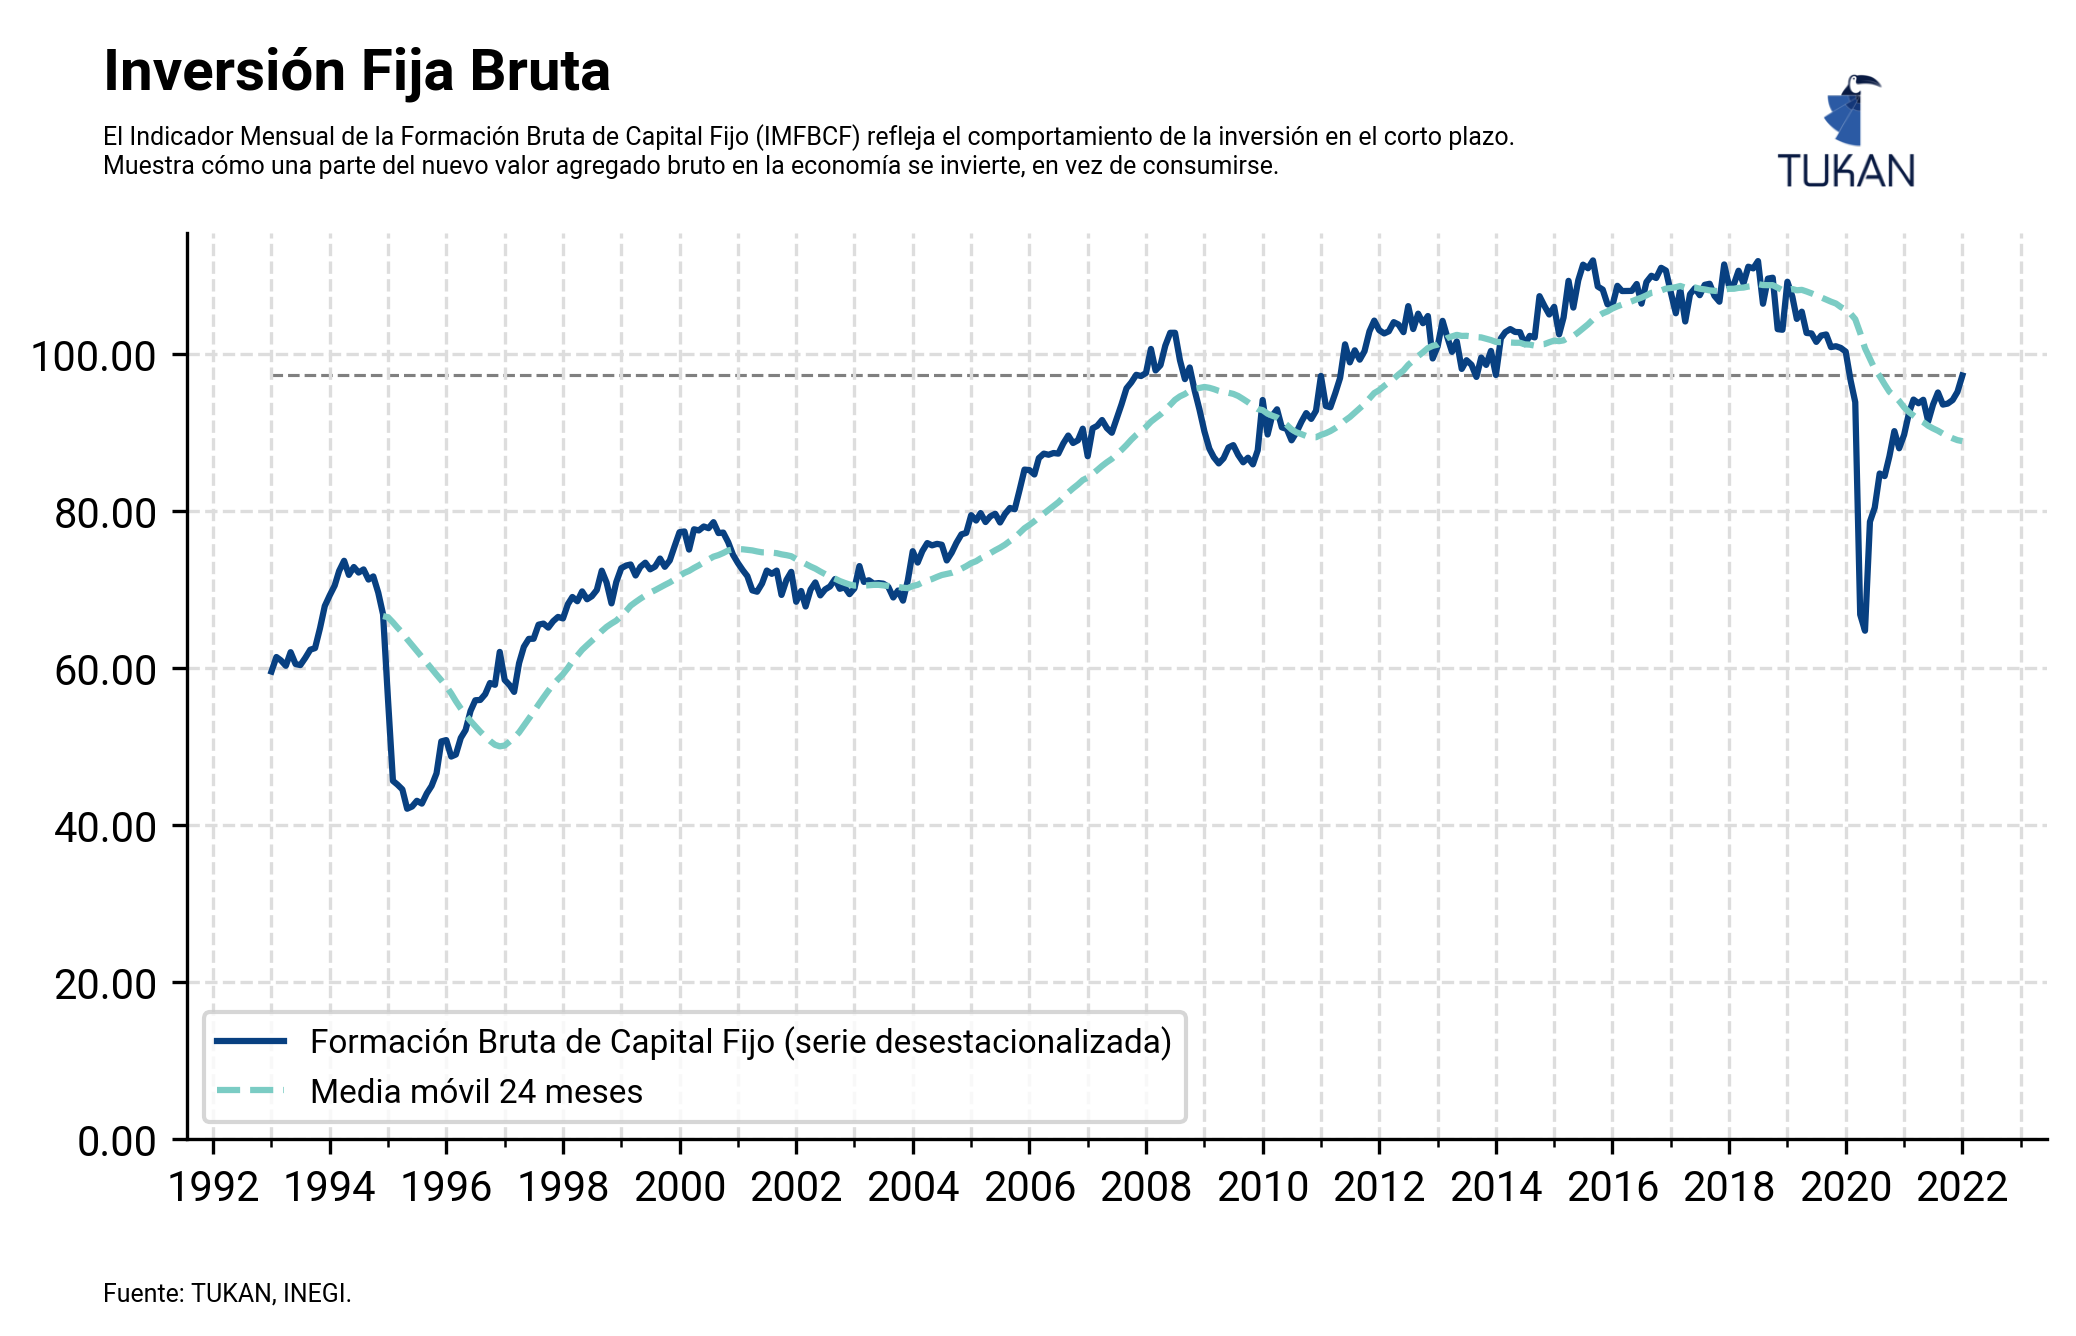

In [41]:
final_data = temp.copy()
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

cmap = mpl.cm.get_cmap("GnBu_r", 5)

ax.plot(final_data["date"], final_data["01a24841a9090de"], color = cmap(0),
        label = "Formación Bruta de Capital Fijo (serie desestacionalizada)")
ax.plot(final_data["date"], final_data["ma_12m"], color = cmap(2),  ls = "--", label = "Media móvil 24 meses")

Y_last = final_data["01a24841a9090de"].iloc[-1]
ax.hlines(Y_last, xmin = final_data["date"].min(), xmax = final_data["date"].max(), ls = "--", color = "gray", lw = .75, zorder = 0)

presidents = list(final_data["president"].unique())


ax.legend(fancybox = True, fontsize = 8, frameon = True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='both', linestyle='--', color = "#dddddd")

ax.set_ylim(0)

fig.text(
    0.09,
    1,
    "Inversión Fija Bruta",
    size=14,
    weight = "bold",
    font = "Roboto"
)
fig.text(
    0.09,
    0.93,
    "El Indicador Mensual de la Formación Bruta de Capital Fijo (IMFBCF) refleja el comportamiento de la inversión en el corto plazo.\nMuestra cómo una parte del nuevo valor agregado bruto en la economía se invierte, en vez de consumirse.",
    size=6
)
# Add footer
fig.text(0.09, -0.01, "Fuente: TUKAN, INEGI.", fontsize=6)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/imfbcf_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.14, 0.17], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/imfbcf_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/imfbcf_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Presidential plot

In [8]:
from highlight_text import HighlightText, ax_text, fig_text

In [9]:
# from highlight_text import ax_text

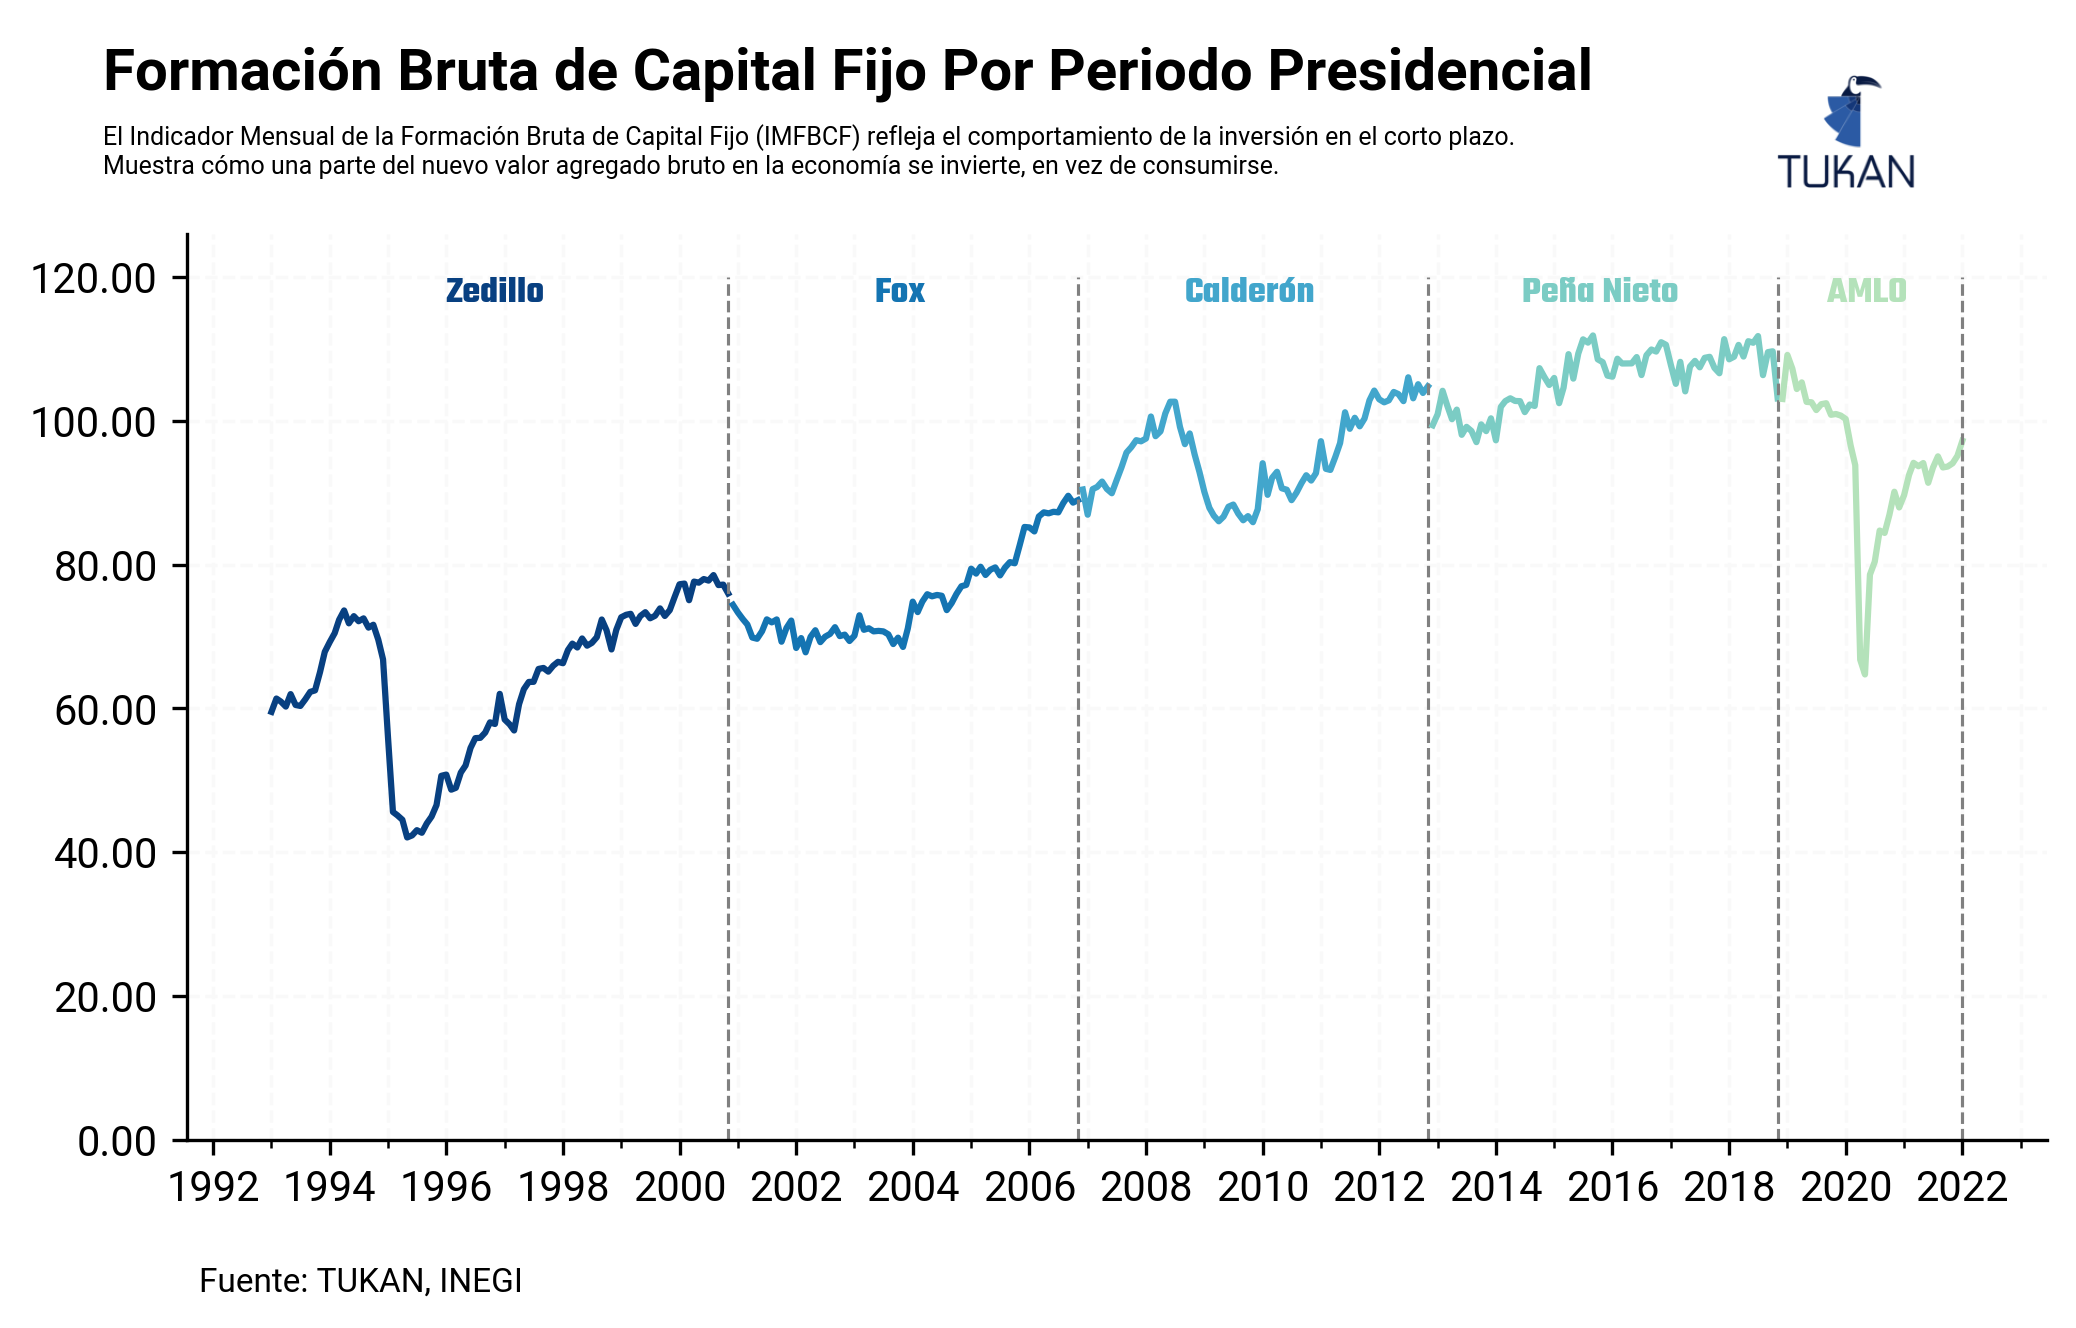

In [40]:
final_data = imfbcf.copy()
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

presidents = list(final_data["president"].unique())

cmap = mpl.cm.get_cmap("GnBu_r", len(presidents) + 2)

for index, x in enumerate(presidents):
    ax.plot(final_data[final_data["president"] == x]["date"], final_data[final_data["president"] == x]["01a24841a9090de"], color = cmap(index))

    X_max = final_data[final_data["president"] == x]["date"].max()
    X_min = final_data[final_data["president"] == x]["date"].min()
    center_date = X_min + ((X_max - relativedelta(months=2)) - X_min)/2

    ax.vlines(X_max, ymin = 0, ymax = 120, color = "gray", ls = "--", lw = .75)
    ax_text(x = center_date, y = 120,
            s = f"<{x}>",
            highlight_textprops=[{"color": cmap(index)}] ,
            ax = ax, weight = "bold", font = "Teko", ha = "center", size = 9)
 

# ax.set_gid(color = "#dddddd")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='both', linestyle='--', color = "#f9f9f9")

ax.set_ylim(0)

fig.text(
    0.09,
    1,
    "Formación Bruta de Capital Fijo Por Periodo Presidencial",
    size=14,
    weight = "bold",
    font = "Roboto"
)
fig.text(
    0.09,
    0.93,
    "El Indicador Mensual de la Formación Bruta de Capital Fijo (IMFBCF) refleja el comportamiento de la inversión en el corto plazo.\nMuestra cómo una parte del nuevo valor agregado bruto en la economía se invierte, en vez de consumirse.",
    size=6
)
# Add footer
fig.text(0.13, -0.001, "Fuente: TUKAN, INEGI", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/imfbcf_presidential_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.14, 0.17], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/imfbcf_presidential_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/imfbcf_presidential_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)